In [2]:
import scipy.io as sio
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from sys import stdout
import os
import sys
import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns 
from scipy.signal import savgol_filter
from scipy.optimize import minimize_scalar
import scipy.linalg as linalg
from cycler import cycler

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
    cross_validate, StratifiedKFold

from Spectral_Utilities import GlobalStandardScaler, EmscScaler

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback




def set_reproducible():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

In [3]:
df1 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\Wheat_Proteine_100_Wang\\Xcal.csv", delimiter=None, sep = ';', header=0)
df2 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\Wheat_Proteine_100_Wang\\Xval.csv", delimiter=None, sep = ';', header=0)
df3 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\Wheat_Proteine_100_Wang\\Ycal.csv", delimiter=None, sep = ';', header=0)
df4 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\Wheat_Proteine_100_Wang\\Yval.csv", delimiter=None, sep = ';', header=0)

In [4]:
df1.shape, df2.shape, df3.shape, df4.shape

((80, 701), (20, 701), (80, 1), (20, 1))

### Concaténenons les deux sous-ensembles de données et les melanger de manière aléatoire en utilisant le même `random_state` pour s'assurer que X et Y sont combiner de la même manière

In [5]:
X1 = shuffle(np.concatenate([df1, df2]),random_state=42)
Y1 = shuffle(np.concatenate([df3, df4]),random_state=42)
X1.shape, Y1.shape

((100, 701), (100, 1))

## Tracé de 50 spectres

In [6]:
#X1 = X[:, :700]
#l = np.arange(600, 1301, 1)
#P_= plt.plot(l,X[0:50].T)

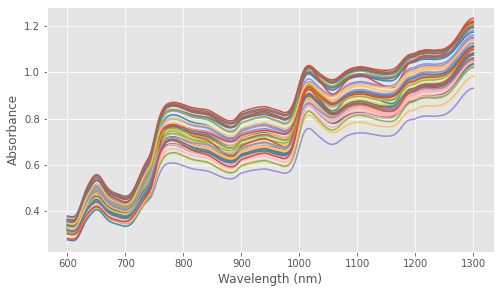

In [7]:
#X1 = X[:, :700]

l = np.arange(600, 1301, 1)
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(l, X1[0:50].T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.show()

### Ce ci est la courbe que nous voulons prédire

Text(0, 0.5, 'Y value')

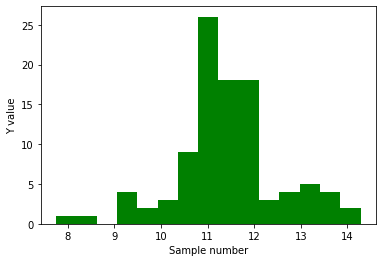

In [8]:
np.histogram(Y1, bins = 10)
plt.hist(Y1, bins=15, color= 'g')
plt.xlabel('Sample number')
plt.ylabel('Y value')

Text(0, 0.5, 'Y value')

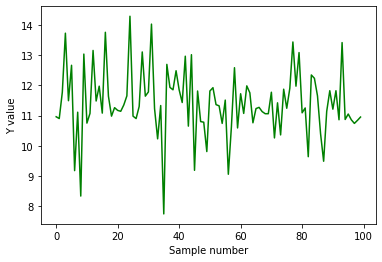

In [9]:
plt.plot(Y1[:,0],'g',label='Y')
plt.xlabel('Sample number')
plt.ylabel('Y value')
#plt.legend()

## Partial Least Squares Regression

In [10]:
#df = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\peach_spectra_brix.csv")


In [11]:
X_train = df1
Y_train = df3
X_test = df2
Y_test = df4

In [12]:
# Define PLS object
pls = PLSRegression(n_components=5)
 
# Fit
pls.fit(X_train, Y_train)
 
# Score
print(f"PLS r-squared {pls.score(X_train, Y_train):.3f}")


PLS r-squared 0.716


In [13]:
# Cross-validation
y_cv = cross_val_predict(pls, X1, Y1, cv=10)
 
# Calculate scores
score = r2_score(Y1, y_cv)
mse = mean_squared_error(Y1, y_cv)

print(f"The MSE is {mse:.3f}")
print(f"The Score is {score:.3f}")

The MSE is 0.499
The Score is 0.591


### Simple convolutional neural network (CNN)

In [14]:
Xcal = X_train

In [15]:
Xcal.shape[1]

701

In [16]:

DENSE = 128
DROPOUT = 0.5

activation='relu'

input_dim = X_train.shape[1]

def make_model():
    model = Sequential()
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(8, (32), activation=activation, padding="same"))
    model.add(Conv1D(16, (32), activation=activation, padding="same" ))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))

    return model

In [17]:
model = make_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 701)              0         
 se)                                                             
                                                                 
 reshape (Reshape)           (None, 701, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 701, 8)            264       
                                                                 
 conv1d_1 (Conv1D)           (None, 701, 16)           4112      
                                                                 
 flatten (Flatten)           (None, 11216)             0         
                                                                 
 dropout (Dropout)           (None, 11216)             0         
                                                        

C:\Users\DASSEBE\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizer_v2\adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [18]:
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train, Y_train, epochs=100, batch_size=8, validation_data=(X_test, Y_test), callbacks=[rdlr])

Epoch 1/100
10/10 [==============================] - 1s 43ms/step - loss: 130.2373 - val_loss: 113.5152 - lr: 0.0100
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 110.9088 - val_loss: 94.0971 - lr: 0.0100
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 89.1909 - val_loss: 72.1015 - lr: 0.0100
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 65.2986 - val_loss: 46.5873 - lr: 0.0100
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 37.5642 - val_loss: 20.9533 - lr: 0.0100
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 14.6664 - val_loss: 4.5777 - lr: 0.0100
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 3.7359 - val_loss: 0.5994 - lr: 0.0100
Epoch 8/100
10/10 [==============================] - 0s 32ms/step - loss: 1.8957 - val_loss: 0.3349 - lr: 0.0100
Epoch 9/100
10/10 [==============================] - 0s 31ms/step - loss: 1.6001 -

### Entrainement sur 100 epochs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


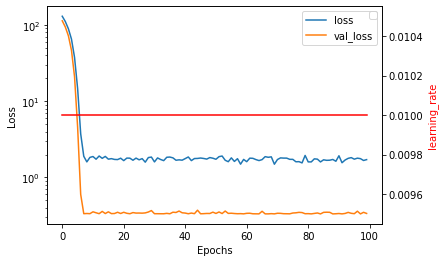

In [19]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('learning_rate',color='r')

_ = plt.legend()

### Entrainement sur 500 epochs

In [20]:
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train, Y_train, epochs=500, batch_size=8, validation_data=(X_test, Y_test), callbacks=[rdlr])

Epoch 1/500
10/10 [==============================] - 0s 24ms/step - loss: 1.5733 - val_loss: 0.3332 - lr: 0.0100
Epoch 2/500
10/10 [==============================] - 0s 21ms/step - loss: 1.7726 - val_loss: 0.3435 - lr: 0.0100
Epoch 3/500
10/10 [==============================] - 0s 21ms/step - loss: 1.7872 - val_loss: 0.3461 - lr: 0.0100
Epoch 4/500
10/10 [==============================] - 0s 23ms/step - loss: 1.7855 - val_loss: 0.3434 - lr: 0.0100
Epoch 5/500
10/10 [==============================] - 0s 19ms/step - loss: 1.6226 - val_loss: 0.3343 - lr: 0.0100
Epoch 6/500
10/10 [==============================] - 0s 23ms/step - loss: 1.6849 - val_loss: 0.3403 - lr: 0.0100
Epoch 7/500
10/10 [==============================] - 0s 19ms/step - loss: 1.6259 - val_loss: 0.3321 - lr: 0.0100
Epoch 8/500
10/10 [==============================] - 0s 19ms/step - loss: 1.5975 - val_loss: 0.3323 - lr: 0.0100
Epoch 9/500
10/10 [==============================] - 0s 19ms/step - loss: 1.7238 - val_loss: 0.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


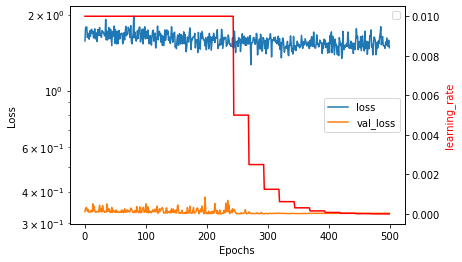

In [21]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('learning_rate',color='r')

_ = plt.legend()

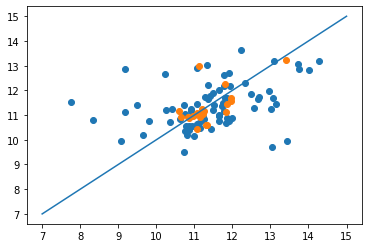

In [22]:
plt.scatter(Y_train, model.predict(X_train))
plt.scatter(Y_test, model.predict(X_test))
plt.plot([7,15],[7,15]) # Y = PredY line

### Huber loss et RMSE

In [23]:
def huber(y_true, y_pred, delta=1.0):
    
	return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))



huber_score=make_scorer(huber)

In [24]:
def metrics(X_train,y_train,X_test, y_test, model):
    rmse = np.mean((y_train - model.predict(X_train))**2)**0.5
    rmse_test = np.mean((y_test - model.predict(X_test))**2)**0.5
    hub = huber(y_train, model.predict(X_train))
    hub_test = huber(y_test, model.predict(X_test))
    print ("RMSE  Train/Test\t%0.2F\t%0.2F"%(rmse, rmse_test))
    print ("Huber Train/Test\t%0.4F\t%0.4F"%(hub, hub_test))

In [25]:
huber(Y_test, model.predict(X_test),  delta = 1.0)

x    0.127211
dtype: float64

In [26]:
metrics(X_train, Y_train, X_test, Y_test, model)

RMSE  Train/Test	1.20	0.57
Huber Train/Test	0.4311	0.1272


## Comparerons les performances avec celles utilisant l'augmentation de données

### l'augmentation de données

Au lieu de corriger ou ameliorer le model de base ``Simple CNN``, nous utilisons la méthode d'augmentation de données. L'idée est de simuler la forme attendue de bruit et de s'attendre à ce que le réseau de neurones
extraie des caractéristiques robustes aux variations ou alors trouve les meilleures corrections pendant l'entraînement. 

In [27]:

def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

### Essayons d'augmenter `le cinquième spectre` pour illustrer ce que fait ``l'augmentation de données``, 

#### Avec de grandes constantes

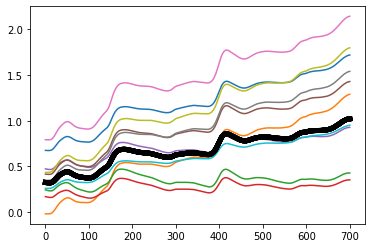

In [28]:

X = X_train[4:5]
X = np.tile(X, (10, 1))
X_aug = dataaugment(X,betashift = 0.5, slopeshift = 0.5,multishift = 0.5)
    
plt.plot(X_aug.T)
_= plt.plot(X.T, lw=5, c='k')

#### Avec de petites constantes

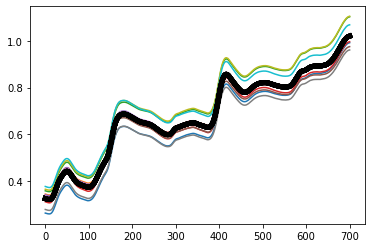

In [29]:

X = X_train[4:5]
X = np.tile(X, (10, 1))
X_aug = dataaugment(X,betashift = 0.05, slopeshift = 0.05,multishift = 0.05)
    
plt.plot(X_aug.T)
_= plt.plot(X.T, lw=5, c='k')

``La large ligne noire est le spectre d'origine et les autres sont les modifiées``

### Suppression des valeurs aberrantes (Outlier)

Vous voudrez utiliser le **Huber loss** chaque fois que vous aurez besoin d'un équilibre entre donner un peu de poids aux valeurs aberrantes, mais pas trop. Pour les cas où les valeurs aberrantes sont très importantes pour vous, utilisez le **MSE**  Dans le cas où vous ne souciez pas du tout des valeurs aberrantes, utilisez le **MAE**!"

In [30]:
def pls_data_optimization(X, Y, plot_components=False):
    
    cv_huber=[]
    component = np.arange(1, 40)
    for i in component:
        pls = PLSRegression(n_components=i)
        cv_score=cross_val_score(pls, X, Y, cv=KFold(10, shuffle = True),\
                        n_jobs=-1, scoring=huber_score)
        cv_huber.append(np.mean(cv_score))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum
    cv_hubermin = np.argmin(cv_huber)
    print("Suggested number of components based in Mean of 10 CV huber loss: ", cv_hubermin+1)
    print('Minimum found in Mean of 10 CV huber loss: {}'.format(np.min(cv_huber)))
    stdout.write("\n")
 
    # Define PLS with suggested number of components and fit train data
    pls = PLSRegression(n_components=cv_hubermin+1)
    pls.fit(X, Y)
    
    # Get predictions for calibration(train) and validation(test) sets
    Y_pred = pls.predict(X) 
    
    # Calculate and print scores for validation set
    R2 = r2_score(Y, Y_pred)
    mse = mean_squared_error(Y, Y_pred)
    hub = huber(Y, Y_pred)
    sep = np.std(Y_pred-Y)
    rmse = np.sqrt(mse)
    
    print('\nError metrics for test set:')
    print('R2: %5.3f'  % R2)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse)
    print('Huber loss (huber): %5.3f' % hub)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
 
    # Plot regression and PLS LV search
    rangey = max(Y) - min(Y)
    rangex = max(Y_pred) - min(Y_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        ax1=plt.subplot(1,2,1)
        ax1.plot(component, np.array(cv_huber), '-v', color = 'blue', mfc='blue')
        ax1.plot(component[cv_hubermin], np.array(cv_huber)[cv_hubermin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('Mean of 10 Cross Val Huber loss')
        plt.title('# PLS components')
        plt.xlim(left=-1)

        z = np.polyfit(np.ravel(Y), np.ravel(Y_pred), 1)        
        ax2 = plt.subplot(1,2,2, aspect=1)
        ax2.scatter(Y,Y_pred,c='k',s=2)
        ax2.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y, Y, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.1*rangey, 'R$^{2}=$ %5.3f'  % R2)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.15*rangey, 'RMSE: %5.3f' % rmse)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.2*rangey, 'Huber loss: %5.3f' % hub)
        plt.show()    
    return 

In [31]:
## Function to help find the best number of components of the PLS based in the MSE or Huber Loss
def pls_prediction(X_calib, Y_calib, X_valid, Y_valid, loss='huber', plot_components=False):
    """
    This function finds the optimal number of PLS components (up to 40) that best models the data
    Here we compute some internal metrics based on MSE and Huber loss
    X_calib - The training data X
    Y_calib - The training data Y
    X_valid - The validation or test data X
    Y_valid - The validation or test data Y
    loss - Choose the error metric of the optimization. Options are 'mse' and 'huber'(default)
    plot_components - Plot the model's optimization and optimized model
    """
    #Run PLS including a variable number of components, up to 40,  and calculate MSE and huber loss
    mse = []
    hub = []
    component = np.arange(1, 40)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Fit
        pls.fit(X_calib, Y_calib)
        # Prediction
        Y_pred = pls.predict(X_valid)
        mse_p = mean_squared_error(Y_valid, Y_pred)
        hub_p = huber(Y_valid,Y_pred)
        mse.append(mse_p)
        hub.append(hub_p)
 
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    hubmin = np.argmin(hub)
    print("Suggested number of components based in MSE: ", msemin+1)
    print("Suggested number of components based in huber: ", hubmin+1)
    stdout.write("\n")
 
    # Define PLS with suggested number of components and fit train data
    if loss=='mse':
        pls = PLSRegression(n_components=msemin+1)
        loss_name = 'MSE'
    else:
        pls = PLSRegression(n_components=hubmin+1)
        loss_name='Huber loss'
    pls.fit(X_calib, Y_calib)
    
    Y_calib_pred = pls.predict(X_calib) 
    Y_valid_pred = pls.predict(X_valid) 
    
    # Calculate and print scores for validation set
    R2_p = r2_score(Y_valid, Y_valid_pred)
    mse_p = mean_squared_error(Y_valid, Y_valid_pred)
    hub_p = huber(Y_valid, Y_valid_pred)
    sep = np.std(Y_valid_pred[:,0]-Y_valid)
    rmse_p = np.sqrt(mse_p)
    
    
    print('\nError metrics for test set:')
    print('R2: %5.3f'  % R2_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
   
    # Plot regression and figures of merit
    rangey = max(Y_valid) - min(Y_valid)
    rangex = max(Y_valid_pred) - min(Y_valid_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        ax1=plt.subplot(1,2,1)
        if loss=='mse':
            ax1.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            ax1.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        else:
            ax1.plot(component, np.array(hub), '-v', color = 'blue', mfc='blue')
            ax1.plot(component[hubmin], np.array(hub)[hubmin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel(loss_name)
        plt.title('# PLS components')
        plt.xlim(left=-1)

        z = np.polyfit(np.ravel(Y_valid), np.ravel(Y_valid_pred), 1)        
        ax2 = plt.subplot(1,2,2, aspect=1)
        ax2.scatter(Y_calib,Y_calib_pred,c='k',s=2)
        ax2.scatter(Y_valid,Y_valid_pred,c='r',s=2)
        ax2.plot(Y_valid, z[1]+z[0]*Y_valid, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y_valid, Y_valid, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.1*rangey, 'R$^{2}=$ %5.3f'  % R2_p)
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        
        plt.show()    
    return Y_calib, Y_valid, Y_valid_pred, Y_calib_pred   


In [54]:
## Function that computes the PLS model and metrics for a train - test set pair and a given number of LV
def pls_prediction_2(X_calib, Y_calib, X_valid, Y_valid, components, plot_components=False):
    """
    Very similar to the two previous functions but without the optimization part
    This function is simply used to compute the PLS model and the error metrics.
    NOTE: For the final error metrics we should use the benchmark() because we need
    take into consideration the unscaled version of the data.
    """
    i=components
    pls = PLSRegression(n_components=i)
    # Fit
    pls.fit(X_calib, Y_calib)
    # Prediction
    Y_pred = pls.predict(X_valid)
         
    # Calculate and print scores
    score_p = r2_score(Y_valid, Y_pred)
    mse_p = mean_squared_error(Y_valid, Y_pred)
    hub_p = huber(Y_valid, Y_pred)
    rmse_p = np.sqrt(mse_p)
    y_err = Y_valid-Y_pred
    sep = np.std(Y_pred-Y_valid)
  
    print('R2: %5.3f'  % score_p)
#    print('Mean Squared Error (MSE): %5.3f' % mse_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
    
    # Plot regression and figures of merit
    rangey = Y_valid.max() - Y_valid.min()
    rangex = Y_pred.max() - Y_pred.min()
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        z = np.polyfit(np.ravel(Y_valid), np.ravel(Y_pred), 1)
        ax2 = plt.subplot(aspect=1)
#         ax2.fill_between(Y_cal, y_est-y_err, y np.ravel(z[1]+z[0]*np.arange(150,240))-2.5*sep, facecolor='red', alpha=0.5)
        ax2.scatter(Y_valid,Y_pred,c='r',s=2)
        ax2.plot(Y_valid, z[1]+z[0]*Y_valid, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y_valid, Y_valid, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(Y_pred.min()+0.02*rangex, Y_valid.max()-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p)
        plt.text(Y_pred.min()+0.02*rangex, Y_valid.max()-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(Y_pred.min()+0.02*rangex, Y_valid.max()-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        plt.text(Y_pred.min()+0.02*rangex, Y_valid.max()-0.25*rangey, 'SEP: %5.3f' % sep)
        #plt.text(Y_pred.min()+0.02*rangex, Y_valid.max()-0.3*rangey, 'Bias: %5.3f' %  bias)
        plt.show() 
        
    return Y_valid, Y_pred, pls

In [33]:
def benchmark(x_train,y_train,x_test, y_test, model):
    """
    Think of this as:
    model(x_train, y_train) -> trained_model
    predicted_y = trained_model(x_test)
    error_metric = compute_error_between(y_test, predicted_y)
    """
    ## ORIGINAL 
#     rmse = np.mean((y_train - model.predict(X_train).reshape(y_train.shape))**2)**0.5
#     rmse_test = np.mean((y_test - model.predict(X_test).reshape(y_test.shape))**2)**0.5
#     hub = huber(y_train, model.predict(X_train))
#     hub_test = huber(y_test, model.predict(X_test))
    ######
    ## CONVERT Y values to initial scale before computing error metrics 
    y_train_true=yscaler.inverse_transform(y_train)
    y_test_true=yscaler.inverse_transform(y_test)
    y_train_pred=yscaler.inverse_transform(model.predict(x_train)).reshape(y_train_true.shape)
    y_test_pred=yscaler.inverse_transform(model.predict(x_test)).reshape(y_test_true.shape)
    
    ## Compute error metrics
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    R2_train= r2_score(y_train_true, y_train_pred)
    R2_test= r2_score(y_test_true, y_test_pred)
    hub_train = huber(y_train_true, y_train_pred)
    hub_test = huber(y_test_true, y_test_pred)
    
    ## Print stuff
    print('\n\n*********** Benchmark results *********** \n')
    print("R2  \t(Train/Test) = \t{:.3f}\t/  {:.3f}".format(R2_train, R2_test))    
    print("RMSE  \t(Train/Test) = \t{:.3f} \t/  {:.3f}".format(rmse_train, rmse_test))
    print ("Huber \t(Train/Test) = \t{:.3f}\t/  {:.3f}".format(hub_train, hub_test))

#### Find the number of PLS Latent Variables that best simulates **Wheat_Proteine_100_Wang**  dataset


Les deux ensembles de données que j’utilise pour l’instant

    -LUCAS_SOC_Cropland_6111_Nocita ----> Xcal (6111, 4200), Xval (2620, 4200), Ycal (6111, 1),Yval (2620, 1)

    -Wheat_Proteine_100_Wang ----> Xcal (80, 701), Xval (20, 701), Ycal (80, 1), Yval (20, 1))

Concaténer les deux sous-ensembles de données et visualiser la courbe que nous voulons prédire

Appliquer le Partial Least Squares Regression et évaluer la performance

Appliquer un Simple convolutional neural network (CNN)

Huber loss et RMSE

Comparerons les performances avec celles utilisant l'augmentation de données

Suppression des valeurs aberrantes (Outlier)

Trouver la valeur optimale du nombre de composante du PLS basé sur les Huber loss et RMSE et sur la moyenne effectuée de plusieurs Cross Validations

Application du PLS avec le nombre trouvé de variables latentes aux ensembles de données 

Indices des points aberrants dans les deux ensembles de données puis suppression --> meilleur score

Application de EMSC et GlobalStandardScaler --> ajuster la plage des spectres et déplacer la moyenne à 0


100% completed
Suggested number of components based in Mean of 10 CV huber loss:  33
Minimum found in Mean of 10 CV huber loss: 0.05351345868817799


Error metrics for test set:
R2: 1.000
Root Mean Squared Error (RMSE): 0.015
Huber loss (huber): 0.000
Standard Error Prediction (SEP): 0.015


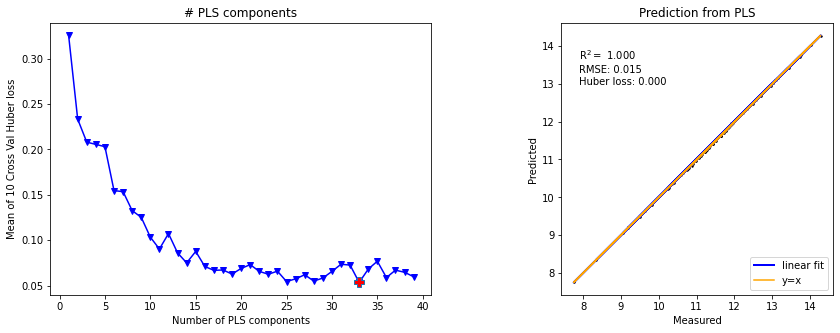

In [34]:
pls_data_optimization(X1, Y1,plot_components=True)

#### Find the number of PLS Latent Variables that best simulates **LUCAS_SOC_Cropland_6111_Nocita**  dataset

In [35]:
df_1 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\LUCAS_SOC_Cropland_6111_Nocita\\Xcal.csv", delimiter=None, sep = ';', header=0)
df_2 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\LUCAS_SOC_Cropland_6111_Nocita\\Xval.csv", delimiter=None, sep = ';', header=0)
df_3 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\LUCAS_SOC_Cropland_6111_Nocita\\Ycal.csv", delimiter=None, sep = ';', header=0)
df_4 = pd.read_csv("C:\\Users\\DASSEBE\\Stage\\TRANSPIR\\BACON\\data\\LUCAS_SOC_Cropland_6111_Nocita\\Yval.csv", delimiter=None, sep = ';', header=0)

In [149]:
df_1.shape, df_2.shape, df_3.shape, df_4.shape

((6111, 4200), (2620, 4200), (6111, 1), (2620, 1))

In [36]:
X2 = shuffle(np.concatenate([df_1, df_2]),random_state=42)
Y2 = shuffle(np.concatenate([df_3, df_4]),random_state=42)
X2.shape, Y2.shape

((8731, 4200), (8731, 1))

100% completed
Suggested number of components based in Mean of 10 CV huber loss:  39
Minimum found in Mean of 10 CV huber loss: 4.502912620773424


Error metrics for test set:
R2: 0.623
Root Mean Squared Error (RMSE): 8.664
Huber loss (huber): 4.429
Standard Error Prediction (SEP): 8.664


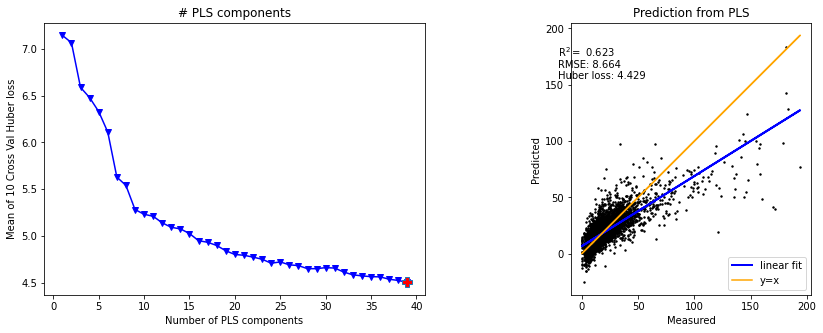

In [148]:
pls_data_optimization(X2, Y2,plot_components=True)

##### Application de PLS avec le nombre trouvé de variables latentes aux ensembles de données 


Optimal PLS model applyed to Wheat_Proteine_100_Wang
R2: 0.815
Root Mean Squared Error (RMSE): 0.268
Huber loss (huber): 0.034
Standard Error Prediction (SEP): 0.261


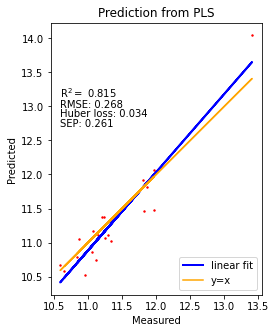

optimal PLS model applyed LUCAS_SOC_Cropland_6111_Nocita
R2: 0.500
Root Mean Squared Error (RMSE): 5.004
Huber loss (huber): 2.913
Standard Error Prediction (SEP): 4.902


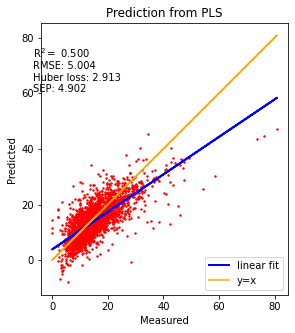

In [56]:
## Visualize the prediction of the PLS model and get the predicted values
print('Optimal PLS model applyed to Wheat_Proteine_100_Wang')    
Yval_1, ypred1, _= pls_prediction_2(df1, df3, df2 , df4, components=33,plot_components=True)     

print('optimal PLS model applyed LUCAS_SOC_Cropland_6111_Nocita')     
Yval_2, ypred2, _= pls_prediction_2(df_1, df_3, df_2 , df_4, components=39,plot_components=True)    

Let's Compute the **absolute prediction error** and find the **index of the data points** where this error is above **2.5** the standard deviation of the error.

In [77]:
## Wheat_Proteine_100_Wang
pred_error1=np.abs(Yval_1-ypred1)
pred_error1_std=pred_error1.std()
print('Standard Deviation of error = {}'.format(pred_error1_std))
ind1=np.ravel(np.where(pred_error1>=2.5*pred_error1_std)).reshape(-1,1)

## LUCAS_SOC_Cropland_6111_Nocita
pred_error2=np.abs(Yval_2-ypred2)
pred_error2_std=pred_error2.std()
print('Standard Deviation of error = {}'.format(pred_error2_std))
ind2=np.ravel(np.where(pred_error2>=2.5*pred_error2_std)).reshape(-1,1)

Standard Deviation of error = x    0.167218
dtype: float64
Standard Deviation of error = x    3.411407
dtype: float64


### Indices des points aberrants dans les deux ensembles de données

In [82]:
print(np.ravel(ind1))
print(np.ravel(ind2))

[ 2  3 10  0  0  0]
[  80  147  156  217  247  262  287  291  292  309  354  366  392  394
  398  412  438  444  449  468  501  522  528  571  595  623  644  691
  704  721  744  766  789  860  900  905  919  925  944  946  957  967
 1041 1043 1046 1048 1053 1059 1060 1068 1072 1077 1079 1081 1094 1097
 1098 1120 1127 1142 1143 1150 1165 1177 1191 1212 1222 1223 1229 1238
 1244 1246 1248 1249 1255 1258 1272 1277 1289 1303 1319 1329 1338 1342
 1365 1366 1386 1391 1406 1407 1422 1428 1433 1434 1451 1458 1459 1470
 1476 1489 1508 1519 1521 1530 1585 1591 1593 1596 1603 1612 1613 1617
 1619 1621 1624 1625 1626 1629 1630 1646 1656 1658 1665 1673 1685 1703
 1709 1711 1741 1766 1770 1771 1818 1825 1828 1840 1868 1884 1912 2009
 2021 2024 2032 2045 2054 2103 2114 2122 2140 2142 2179 2195 2196 2197
 2199 2204 2205 2206 2217 2282 2312 2317 2333 2372 2379 2393 2403 2418
 2435 2505 2514 2560 2574 2597    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  

Supprimons les valeurs aberrantes de l'ensemble de données d'origine et re appliquons PLS

In [91]:
## Recompute PLS for the full clean datasets

print('PLS model for full clean dataset from instrument 1 \n')
X1_clean=np.delete(X1,ind1,axis=0)
Y1_clean=np.delete(Y1,ind1,axis=0)
X2_clean=np.delete(X2,ind2,axis=0)
Y2_clean=np.delete(Y2,ind2,axis=0)

PLS model for full clean dataset from instrument 1 



In [97]:
X1_clean.shape, X1.shape

((96, 701), (100, 701))

In [102]:
X2_clean.shape, X2.shape, X2.shape[0]-X2_clean.shape[0]

((8556, 4200), (8731, 4200), 175)

PLS model for full clean dataset from Wheat_Proteine_100_Wang 

R2: 1.000
Root Mean Squared Error (RMSE): 0.014
Huber loss (huber): 0.000
Standard Error Prediction (SEP): 0.014


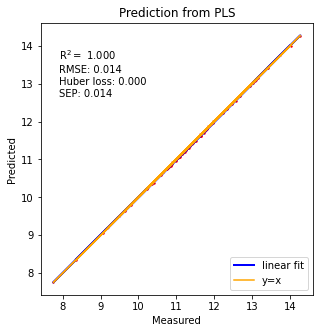

In [104]:
print('PLS model for full clean dataset from Wheat_Proteine_100_Wang \n')

_=pls_prediction_2(X1_clean,Y1_clean, X1_clean , Y1_clean, components=33, plot_components=True)  

PLS model for full clean dataset from LUCAS_SOC_Cropland_6111_Nocita 

R2: 0.622
Root Mean Squared Error (RMSE): 8.661
Huber loss (huber): 4.413
Standard Error Prediction (SEP): 8.661


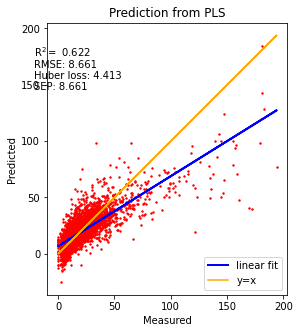

In [109]:
print('PLS model for full clean dataset from LUCAS_SOC_Cropland_6111_Nocita \n')

_=pls_prediction_2(X2_clean,Y2_clean, X2_clean , Y2_clean, components=39, plot_components=True)  

In [106]:
## check for nans
print('NANs on X1_clean? = ',np.isnan(np.sum(X1_clean)))
print('NANs on Y1_clean? = ',np.isnan(np.sum(Y1_clean)))
print('NANs on X2_clean? = ',np.isnan(np.sum(X2_clean)))
print('NANs on Y2_clean? = ',np.isnan(np.sum(Y2_clean)))

NANs on X1_clean? =  False
NANs on Y1_clean? =  False
NANs on X2_clean? =  False
NANs on Y2_clean? =  False


À la suite de la suppression des valeurs aberrantes toutes les mesures d'erreur se sont visiblement améliorées! 

Maintenant que nous nous sommes débarrassés des valeurs aberrantes, passons à l'étape de pré-traitement.

### Data split

In [129]:
## Data from spectrometer 1
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X1_clean, Y1_clean, test_size=0.2, random_state=42)
## Data from spectrometer 2
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X2_clean, Y2_clean, test_size=0.2, random_state=42)

In [125]:
x_test_1 = x_test_1[:,0:700]
x_train_1 = x_train_1[:,0:700]


In [126]:
x_train_1.shape, x_test_1.shape

((76, 700), (20, 700))

GlobalScaling Train1 std:  0.5
GlobalScaling Train1 mean:  1.4403974671914336e-17
GlobalScaling Train1 max:  1.2650481210430935
GlobalScaling Train1 min:  -1.1250521940681006


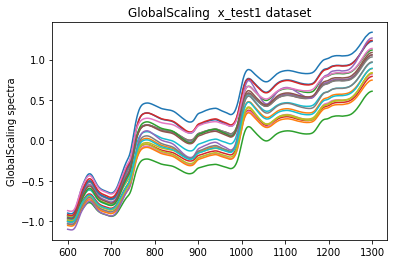

In [133]:
## EMSC(Extended Multiplicative Scatter Correction) correction + GlobalScaling dataset 


## First: do the EMSC correction based only on the unscaled training dataset 1
emsc = EmscScaler()
emsc.fit(x_train_1)




## Second: Rescale the EMSC data (more or less to near [-1, 1])
xscaler0 = GlobalStandardScaler(normfact=2) # normfact=2 ensure that we are dividing by 2. std 

## We use the avalaible data from the training set to create the scaler, and use that 
## same scaler to scale the other (unseen) subsets
x_train1 = xscaler0.fit_transform(x_train_1)

x_train2 = xscaler0.transform(x_train_2)
x_test1 = xscaler0.transform(x_test_1)
x_test2 = xscaler0.transform(x_test_2)

print('GlobalScaling Train1 std: ',x_train1.std())
print('GlobalScaling Train1 mean: ',x_train1.mean())
print('GlobalScaling Train1 max: ',x_train1.max())
print('GlobalScaling Train1 min: ',x_train1.min())

plt.plot(l,x_test1.T)
plt.title('GlobalScaling  x_test1 dataset')
plt.ylabel('GlobalScaling spectra')
plt.show()

Les différences entre les spectres ne sont pas modifiées, mais la plage est ajustée et la moyenne déplacée à zéro.

y_train1 shape=(76, 1), 	 y_test1 shape=(20, 1)


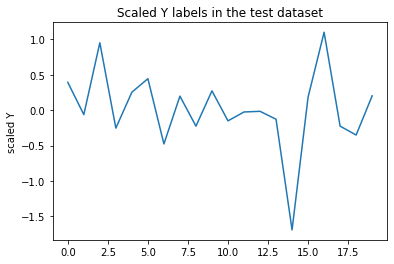

In [137]:

yscaler = GlobalStandardScaler(normfact=2.)
y_train1_scaled = yscaler.fit_transform(y_train_1).reshape(-1,1)
y_train2_scaled = yscaler.transform(y_train_2).reshape(-1,1)
y_test1_scaled = yscaler.transform(y_test_1).reshape(-1,1)
y_test2_scaled = yscaler.transform(y_test_2).reshape(-1,1)

print('y_train1 shape={}, \t y_test1 shape={}'.format(y_train1_scaled.shape,y_test1_scaled.shape))
plt.plot(y_test1_scaled)
plt.title('Scaled Y labels in the test dataset')
plt.ylabel('scaled Y')
plt.show()

In [138]:
## Dimensions sanity check
print(np.shape(x_test1))
print(np.shape(y_test1_scaled))
print(np.shape(x_test2))
print(np.shape(y_test2_scaled))

(20, 701)
(20, 1)
(1712, 4200)
(1712, 1)


In [140]:
x_train_1.shape

(76, 701)

In [142]:
model_gs = make_model()
